In [1]:
import geopandas as gpd # Для парсинга карты
import pandas as pd
import numpy as np
# import cudf

import matplotlib.pyplot as plt # Для отрисовки
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import IPython
def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

In [15]:
# # import pickle
# # t = pickle.load(open('df_ini.pkl', 'br'))
# t.shape

(47186, 37)

In [2]:
# DATASET_FOLDER = 'drive/My Drive/dataset'
# MAPS_FOLDER = f'{DATASET_FOLDER}/maps'

MAPS_FOLDER = './boston_dataset_ini'

In [3]:
# builds = gpd.read_file(f'{MAPS_FOLDER}/building/boston_buildings.shp')
builds = gpd.read_file(f'{MAPS_FOLDER}/building/boston_buildings.shp')
print(builds.shape)
builds.head()

(129370, 29)


,BUILDING_I,PARCEL_ID,ADDRESS_ID,PART_ADDRE,PART_ID,PART_USE,PART_BRA_U,PART_CONTA,PART_STATU,PART_VIEW,...,BUILDING_H,IEL_TYPE,BASE_ELEVA,ELEVATION_,TOP_SEA_LE,ELEVATION1,TOP_GROUND,Shape_area,Shape_len,geometry
0,Bos_2205632000_B0,2205632000,2205632000_A0,"68 KENRICK ST, 02135",Bos_2205632000_B0_M0,R1,R1,MCNAMARA ROBERT O,BUILT,PUBLIC,...,16.890698,BLDG,55.365665,70.138047,74.846878,14.772382,19.481212,1161.397293,149.394841,"POLYGON Z ((746591.271 2951419.399 69.207, 746..."
1,Bos_2102861000_B1,2102861000,2102861000_A0,"53 CHESTNUT HILL AV, 02135",Bos_2102861000_B1_M0,R2,R2,CUNNINGHAM JOHN J,BUILT,PUBLIC,...,36.756003,BLDG,129.925217,137.779148,146.070301,7.853931,16.145084,549.002100,96.663101,"POLYGON Z ((749810.012 2951406.252 137.778, 74..."
2,Bos_2204921000_B0,2204921000,2204921000_A0,"97 ACADEMY HILL RD, 02135",Bos_2204921000_B0_M0,R2,R2,KEEFE EDWARD J,BUILT,PUBLIC,...,21.713000,BLDG,162.142441,184.654210,190.966186,22.511769,28.823745,1456.043245,181.859296,"POLYGON Z ((749458.573 2951325.510 175.721, 74..."
3,Bos_2102862000_B1,2102862000,2102862000_A0,"55 CHESTNUT HILL AV, 02135",Bos_2102862000_B1_M0,R3,R3,CUNNINGHAM JOHN J,BUILT,PUBLIC,...,22.761005,BLDG,131.035858,152.578506,161.123235,21.542647,30.087377,982.054372,135.393057,"POLYGON Z ((749791.436 2951364.987 144.628, 74..."
4,Bos_2102870000_B0,2102870000,2102870000_A0,"15 WM JACKSON AV, 02135",Bos_2102870000_B0_M0,R1,R1,YUNG JIN P,BUILT,PUBLIC,...,20.348997,BLDG,170.059418,184.541181,196.525357,14.481763,26.465939,1167.143115,149.400957,"POLYGON Z ((749737.548 2951033.339 183.535, 74..."


In [4]:
# Пропуски в участках
builds = builds[builds.PARCEL_ID.notna()]
# Выбрасываем участки с количеством домов больше 1 (17 from 130 *10^3)
buildings_ids = builds.PARCEL_ID.value_counts()[builds.PARCEL_ID.value_counts() > 1].index
builds = builds[~builds.PARCEL_ID.isin(buildings_ids)]
# Выбрасываем дважды зарегестрированные дома
buildings_ids = builds.BUILDING_I.value_counts()[builds.BUILDING_I.value_counts()>1].index
builds = builds[~builds.BUILDING_I.isin(buildings_ids)]
# Убираем пропуски в форме здания  и в типе здания
builds = builds[builds.geometry.notna()]
builds = builds[builds.PART_STATU.notna()]
# Количество уникальных участков совпадает с количеством наблюдений
assert builds.PARCEL_ID.nunique() == builds.shape[0]

In [5]:
places = gpd.read_file(f'{MAPS_FOLDER}/parcels/parcels_14.shp')
places.head()

,WARD,PARCEL,PID_LONG,WPD,BATCH,SHAPE_area,SHAPE_len,geometry
0,14,2056,1402056000,14-02-105,0,5757.493630,315.033758,"POLYGON ((769130.915 2932963.653, 769077.636 2..."
1,14,2062,1402062000,14-02-105,0,15992.697124,504.383439,"POLYGON ((768725.435 2932877.770, 768724.966 2..."
2,14,2031,1402031000,14-02-105,0,6848.300234,374.282334,"POLYGON ((768817.544 2933017.601, 768791.533 2..."
3,20,11758-10,2011758010,20-03-011,0,13714.523754,504.092976,"POLYGON ((749271.802 2918978.927, 749392.524 2..."
4,20,11760,2011760000,20-03-011,0,14186.845679,500.495781,"POLYGON ((749411.968 2919142.915, 749259.493 2..."


In [6]:
# Участи, зарегестрированные более 1 раза
place_ids = places.PID_LONG.value_counts()[places.PID_LONG.value_counts() >1].index
places = places[~places.PID_LONG.isin(place_ids)]
# Участки с пропусками
places = places[places.PID_LONG.notna()]
# Количество уникальных участков совпадает с количеством наблюдений
assert places.shape[0] == places.PID_LONG.nunique()

In [7]:
builds.shape, places.shape

((71706, 29), (99241, 8))

In [8]:
print(places.shape, builds.shape)
print('buildings on places', builds.PARCEL_ID.isin(places.PID_LONG.unique()).sum())

(99241, 8) (71706, 29)
buildings on places 71210


In [9]:
df_ini = builds.merge(places,  left_on='PARCEL_ID', right_on='PID_LONG', how='inner')
df_ini.rename(columns={'geometry_x': 'geometry_building',
                       'geometry_y': 'geometry_place'},
              inplace=True)
# df_ini[['geometry_building', 'geometry_place']] = \
#     df_ini[['geometry_building', 'geometry_place']].astype('object')
df_ini.head()

,BUILDING_I,PARCEL_ID,ADDRESS_ID,PART_ADDRE,PART_ID,PART_USE,PART_BRA_U,PART_CONTA,PART_STATU,PART_VIEW,...,Shape_len,geometry_building,WARD,PARCEL,PID_LONG,WPD,BATCH,SHAPE_area,SHAPE_len,geometry_place
0,Bos_2205632000_B0,2205632000,2205632000_A0,"68 KENRICK ST, 02135",Bos_2205632000_B0_M0,R1,R1,MCNAMARA ROBERT O,BUILT,PUBLIC,...,149.394841,"POLYGON Z ((746591.271 2951419.399 69.207, 746...",22,5632,2205632000,22-08-060,0,6147.989082,325.006781,"POLYGON ((746621.759 2951435.076, 746611.102 2..."
1,Bos_2204921000_B0,2204921000,2204921000_A0,"97 ACADEMY HILL RD, 02135",Bos_2204921000_B0_M0,R2,R2,KEEFE EDWARD J,BUILT,PUBLIC,...,181.859296,"POLYGON Z ((749458.573 2951325.510 175.721, 74...",22,4921,2204921000,22-09-020,0,8083.907188,362.749418,"POLYGON ((749402.010 2951291.513, 749435.010 2..."
2,Bos_2102870000_B0,2102870000,2102870000_A0,"15 WM JACKSON AV, 02135",Bos_2102870000_B0_M0,R1,R1,YUNG JIN P,BUILT,PUBLIC,...,149.400957,"POLYGON Z ((749737.548 2951033.339 183.535, 74...",21,2870,2102870000,21-13-005,0,4271.789581,421.615170,"POLYGON ((749743.230 2950985.758, 749714.095 2..."
3,Bos_2102857000_B0,2102857000,2102857000_A0,"86 ACADEMY HILL RD, 02135",Bos_2102857000_B0_M0,R2,R2,JOE CAROL,BUILT,PUBLIC,...,184.331184,"POLYGON Z ((749675.844 2951369.308 177.057, 74...",21,2857,2102857000,21-13-005,0,9911.996103,466.564661,"POLYGON ((749750.445 2951355.464, 749741.850 2..."
4,Bos_2102856000_B0,2102856000,2102856000_A0,"90 ACADEMY HILL RD, 02135",Bos_2102856000_B0_M0,R2,R2,KRIZAN MAGDA,BUILT,PUBLIC,...,181.610025,"POLYGON Z ((749656.610 2951320.949 183.698, 74...",21,2856,2102856000,21-13-005,0,7543.744282,434.782996,"POLYGON ((749737.693 2951282.616, 749733.662 2..."


In [10]:
df_ini = df_ini[df_ini.geometry_place.apply( \
            lambda x: x.geom_type) != 'MultiPolygon']
right_location = df_ini.apply(lambda x: \
                      x.geometry_building.within(x.geometry_place),\
                          axis=1)
df_ini = df_ini[right_location]

In [12]:
df_ini.to_pickle('df_ini.pkl')

In [32]:
features = ['PART_VIEW', 'PART_USE', 'PART_CONTA', 'PART_ADDRE', 'PART_FLOOR']
for f in features:
    print(f, df_ini[f].nunique())

PART_VIEW 1
PART_USE 14
PART_CONTA 44548
PART_ADDRE 46989
PART_FLOOR 41


In [40]:
df_ini.columns

Index(['BUILDING_I', 'PARCEL_ID', 'ADDRESS_ID', 'PART_ADDRE', 'PART_ID',
       'PART_USE', 'PART_BRA_U', 'PART_CONTA', 'PART_STATU', 'PART_VIEW',
       'PART_FOOT', 'PART_ROOF', 'PART_HEIGH', 'PART_FLOOR', 'PART_GROSS',
       'PART_CENTE', 'PART_CEN_1', 'GROUND_ELE', 'ROOF_ELEVA', 'BUILDING_H',
       'IEL_TYPE', 'BASE_ELEVA', 'ELEVATION_', 'TOP_SEA_LE', 'ELEVATION1',
       'TOP_GROUND', 'Shape_area', 'Shape_len', 'geometry_building', 'WARD',
       'PARCEL', 'PID_LONG', 'WPD', 'BATCH', 'SHAPE_area', 'SHAPE_len',
       'geometry_place'],
      dtype='object')

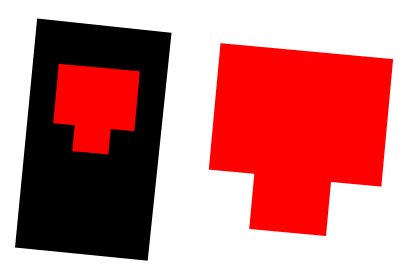

In [46]:
df = df_ini.copy()
# df.rename(columns={'geometry_place': 'geometry'}, inplace=True)
# df = gpd.GeoDataFrame(df)

figsize = (5, 5)


x = df_ini.iloc[0,29:].copy()
area = gpd.GeoDataFrame(geometry=pd.Series(x.geometry_place))
    # take data for buiding and plot on the same axis
x = df_ini.iloc[0, :29].copy()
building = gpd.GeoDataFrame(geometry=pd.Series(x.geometry_building))
    
# plot
# area 
ax = plt.subplot(121)
ax.set_axis_off()
area.plot(color='000', figsize=figsize, ax=ax)
building.plot(color='red', figsize=figsize, ax=ax)
ax = plt.subplot(122)
ax.set_axis_off()
building.plot(color='red', figsize=figsize, ax=ax)
plt.tight_layout()
# plt.savefig(f'{DATASET_FOLDER}/areas/area_{x.name}.png',\
#            dpi=dpi)   
#     plt.close('all')
    



# ax = plt.subplot(111)#
# t = gpd.GeoDataFrame(df[df.PID_LONG=='2205632000'].geometry)
# ax = plt.plot(df['building_x'].loc[0:0].to_array(), 
#               df['building_y'].loc[0:0].to_array(), \
#        #color='000', figsize=figsize,)
#               #
#              )
# ax.set_axis_off()

# df = df_ini.iloc[:,:29].copy()
# df.rename(columns={'geometry_building': 'geometry'}, inplace=True)
# # df = gpd.GeoDataFrame(df)

# t = gpd.GeoDataFrame(df[df.PARCEL_ID=='2205632000'].geometry)
# t.plot(color='r', figsize=figsize, ax=ax)
plt.show()

In [52]:
plt.style.use('default')

In [61]:
from tqdm import tqdm

DATASET_FOLDER = './dataset'
figsize = (3, 3)

def plot_dataset(x_ini):
    '''create 3 type of sample pictures to DATASET_FOLDER:
     - building footprint, 
     - area/place,
     - combine both
    x_ini - pandas Series with featers for biuldings (first 29) and features for area (others)
    '''
    
    dpi=40
    # take data for place
    x = x_ini.iloc[29:].copy()
    area = gpd.GeoDataFrame(geometry=pd.Series(x.geometry_place))
    # take data for buiding and plot on the same axis
    x = x_ini.iloc[:29].copy()
    building = gpd.GeoDataFrame(geometry=pd.Series(x.geometry_building))
    
    # plot
    # area 
    ax = plt.subplot(111)
    ax.set_axis_off()
    area.plot(color='000', figsize=figsize, ax=ax)
    plt.tight_layout()
    plt.savefig(f'{DATASET_FOLDER}/areas/area_{x.name}.png',\
               dpi=dpi)   
    plt.close('all')
    
    ax2 = plt.subplot(111)
    ax2.set_axis_off()
    building.plot(color='000', figsize=figsize, ax=ax2)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    ax2.axis(xmin=xl[0],xmax=xl[1], ymin=yl[0], ymax=yl[1])
    plt.tight_layout()
    plt.savefig(f'{DATASET_FOLDER}/buildings/building_{x.name}.png',
               dpi=dpi)   
    plt.close('all')
    
    ax = plt.subplot(111)
    ax.set_axis_off()
    area.plot(color='000', figsize=figsize, ax=ax)
    building.plot(color='r', figsize=figsize, ax=ax)
    plt.tight_layout()
    plt.savefig(f'{DATASET_FOLDER}/combined/total_{x.name}.png',
               dpi=dpi,
#                 bbox_inches='tight')   
               )
    plt.close('all')   
    
    ax = plt.subplot(121)
    ax.set_axis_off()
    area.plot(color='000', figsize=figsize, ax=ax)
    plt.tight_layout()
    ax2 = plt.subplot(122)
    ax2.set_axis_off()
    building.plot(color='000', figsize=figsize, ax=ax2)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    ax2.axis(xmin=xl[0],xmax=xl[1], ymin=yl[0], ymax=yl[1])
    plt.tight_layout()
    
    plt.savefig(f'{DATASET_FOLDER}/closer/both_{x.name}.png',
               dpi=dpi)png
    

  0%|          | 188/47186 [00:26<1:50:11,  7.11it/s]


KeyboardInterrupt: 

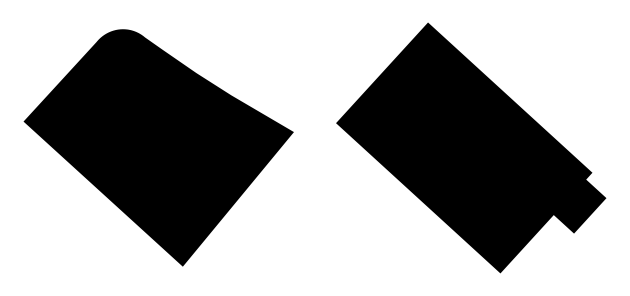

In [63]:
tqdm.pandas()
df_ini.progress_apply(plot_dataset, axis=1)